In [97]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(16,8))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p
import lin_lib as ll
import demodulation_lib as dl

from pysimulators import FitsArray

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import scipy.signal as scsig
from scipy import interpolate

## Dataset
Between March 13th 2019 and March 17th 2019 we have performed 4 series of scans, each starting at -XX in elevation (w.r.t. rest position==50 deg.) and then making 40 azimuth scans, each from -20 to 20 degrees. After each azimuth scan, the elevation is increased by 1 degree (not encoder degrees, only step motors, so with a significant uncertainty, but Louise has done some calibration of this).

Here is a description of each dataset:
1. "ScanMap": from 2019-03-13 @ 19h21 to 2019-03-14 @ 11h03 
    - First scan from -20 in elevation to +20, therefore actual elevation from 30 to 70
    - To be analyzed
2. "ScanMapNew": from 2019-03-14 @ 13h22 to 15h34, then 2019-03-15 @ 13h42 to 14h13
    - Many GPS issues with this scan
    - finally interrupted. 
    - Not to be analaysed in priority
3. "ScanMapNew2": from 2019-03-15 @ 17h21 to 2019-03-16 @ 9h17
    - Scan from -20 in elevation to +20, therefore actual elevation from 30 to 70
    - Cycle finished at scan 38 or 39 => take care of this
    - to be analysed
4. "ScanMapNew2_Start_40.5": from 2019-03-16 @ 20h17 to 2019-03-17 @ 12h15
    - Scan started at el-19.5 to + 20.5: therefore actual elevation 30.5 to 70.5
    - to be analyzed
    
Lets get the directories corresponding to each dataset:

In [98]:
names = ['ScanMap', 'ScanMapNew2', 'ScanMapNew2_start-40.5']
days = [['2019-03-13', '2019-03-14'], ['2019-03-15', '2019-03-16'], ['2019-03-16', '2019-03-17']]
el_start = [30., 30., 30.5]
delta_el = 1.

all_elevation = []
datasets=[]
for inames in xrange(len(names)):
    n = names[inames]
    print n, ' Elevation starts at {}'.format(el_start[inames])
    datasets.append([])
    for d in days[inames]:
        dd = glob.glob('/qubic/Data/Calib-TD/'+d+'/*'+n)
        for i in xrange(len(dd)): 
            datasets[inames].append(dd[i])
        print '  * ',d,' : {} files'.format(len(dd))
    print '  => Total = {} files'.format(len(datasets[inames]))
    elevations = el_start[inames]+arange(len(datasets[inames]))*delta_el
    all_elevation.append(elevations)
    print '  => Elevation ends at {}'.format(np.max(elevations))


ScanMap  Elevation starts at 30.0
  *  2019-03-13  : 12 files
  *  2019-03-14  : 29 files
  => Total = 41 files
  => Elevation ends at 70.0
ScanMapNew2  Elevation starts at 30.0
  *  2019-03-15  : 17 files
  *  2019-03-16  : 24 files
  => Total = 41 files
  => Elevation ends at 70.0
ScanMapNew2_start-40.5  Elevation starts at 30.5
  *  2019-03-16  : 10 files
  *  2019-03-17  : 31 files
  => Total = 41 files
  => Elevation ends at 70.5


We start with the forst dataset ('ScanMap'):

In [99]:
index = 0
dirs = datasets[index]
elevation = all_elevation[index]

labels = []
dir_time = []
for d in dirs:
    bla = str.split(d,'__')
    blo = str.split(bla[0],'/')
    labels.append(bla[1])
    dir_time.append(blo[-1])
    
for i in xrange(len(labels)): 
    print labels[i], dir_time[i], 'Elevation: ', elevation[i]


ScanMap 2019-03-13_19.21.34 Elevation:  30.0
ScanMap 2019-03-13_19.45.19 Elevation:  31.0
ScanMap 2019-03-13_20.05.14 Elevation:  32.0
ScanMap 2019-03-13_20.32.18 Elevation:  33.0
ScanMap 2019-03-13_20.53.48 Elevation:  34.0
ScanMap 2019-03-13_21.07.38 Elevation:  35.0
ScanMap 2019-03-13_21.42.35 Elevation:  36.0
ScanMap 2019-03-13_22.06.20 Elevation:  37.0
ScanMap 2019-03-13_22.30.05 Elevation:  38.0
ScanMap 2019-03-13_22.53.50 Elevation:  39.0
ScanMap 2019-03-13_23.17.35 Elevation:  40.0
ScanMap 2019-03-13_23.41.20 Elevation:  41.0
ScanMap 2019-03-14_00.05.05 Elevation:  42.0
ScanMap 2019-03-14_00.28.45 Elevation:  43.0
ScanMap 2019-03-14_00.39.47 Elevation:  44.0
ScanMap 2019-03-14_01.04.00 Elevation:  45.0
ScanMap 2019-03-14_01.38.49 Elevation:  46.0
ScanMap 2019-03-14_01.48.41 Elevation:  47.0
ScanMap 2019-03-14_02.25.42 Elevation:  48.0
ScanMap 2019-03-14_02.49.28 Elevation:  49.0
ScanMap 2019-03-14_03.13.13 Elevation:  50.0
ScanMap 2019-03-14_03.36.59 Elevation:  51.0
ScanMap 20

And we first start with the middle file: i=21

In [247]:
ii = 25
thedir = datasets[index][ii]
print thedir, 'Elevation =',all_elevation[index][ii]

/qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap Elevation = 55.0


## Reading Data for a given asic

In [248]:
AsicNum = 1
a = qp()
a.read_qubicstudio_dataset(thedir, asic=AsicNum)

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap/Sums/science-asic1-2019.03.14.050226.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap/Sums/science-asic1-2019.03.14.050226.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap/Hks/hk-MMR-2019.03.14.050226.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap/Hks/hk-MMR-2019.03.14.050226.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap/Hks/hk-intern-2019.03.14.050226.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap/Hks/hk-intern-2019.03.14.050226.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.26__ScanMap/Hks/conf-asics-2019.03.14.050229.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-14/2019-03-14_05.02.

## Reading TES data

Bad GPS Data!
ERROR! Bad GPS data.  Using sample rate to make a time axis.


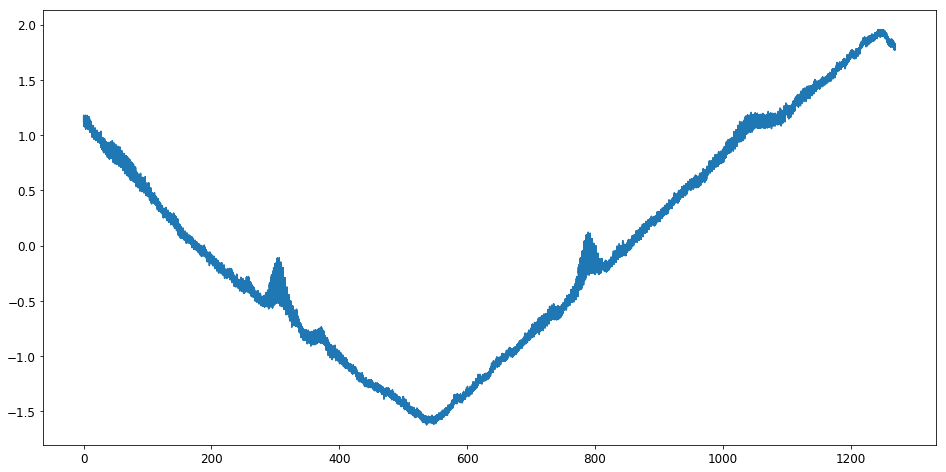

In [249]:
TESNum = 93
data = a.timeline(TES=TESNum)
t_data = a.timeline_timeaxis(axistype='pps')

plot(t_data-t_data[0], (data-np.mean(data))/np.std(data), label='Data')
#a.plot_timestamp_diagnostic()

## Reading Azimuth Data

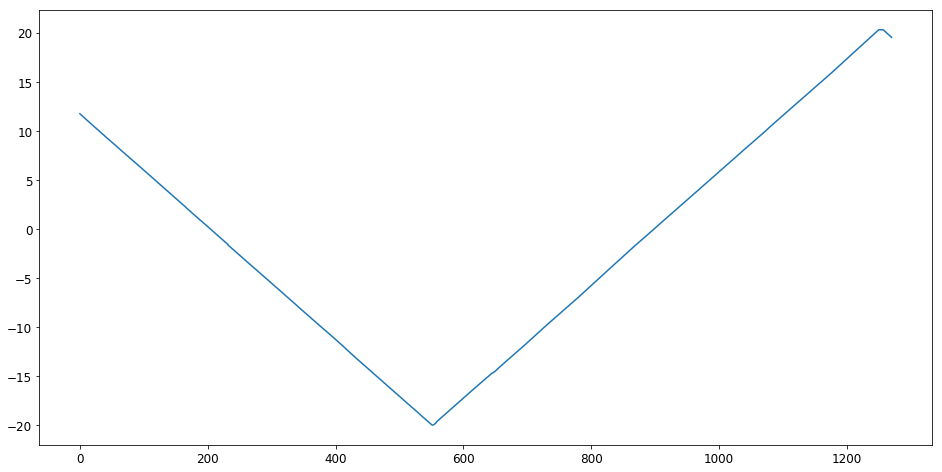

In [250]:
az = a.azimuth()
#t_az = a.timeaxis(datatype='hk',axistype='index')
t_az = (np.max(t_data)-np.min(t_data))*np.linspace(0,1,len(az))

plot(t_az, az)

### Plot Data and Azimuth together (they should match)

(-5, 5)

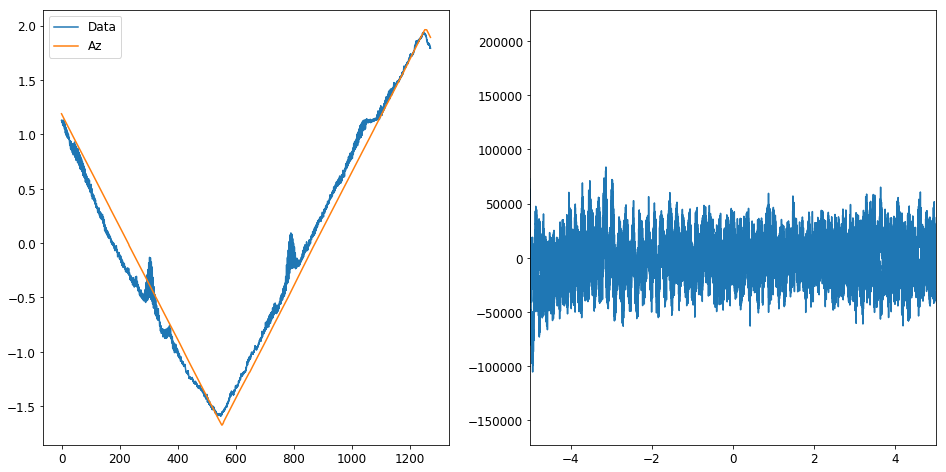

In [251]:
subplot(1,2,1)
plot(t_data, f.gaussian_filter1d((data-np.mean(data))/np.std(data),15), label='Data')
plot(t_az, (az-np.mean(az))/np.std(az), label='Az')
legend()

subplot(1,2,2)
plot(np.interp(t_data, t_az, az), data-f.gaussian_filter1d(data,1000))
xlim(-5,5)

Let's check the modulation frequency (main peak in data)

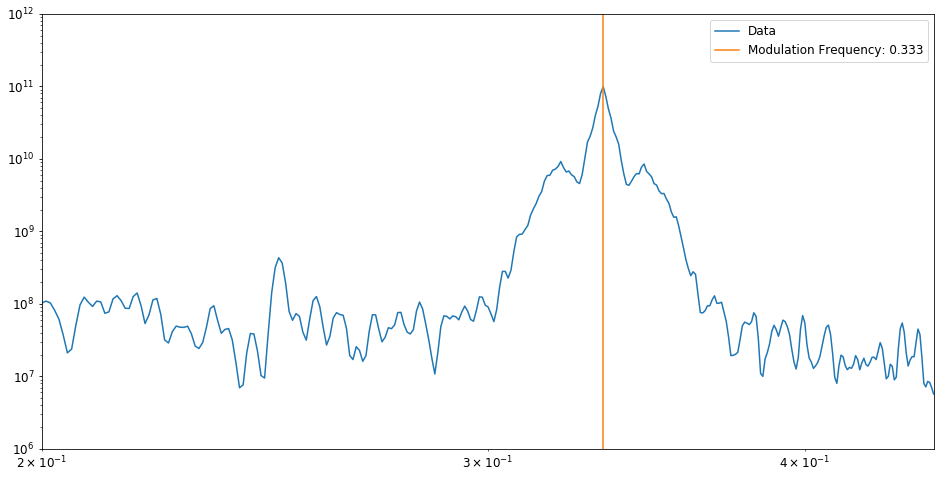

In [252]:
FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data), window=mlab.window_hanning)
plot(freq_f, f.gaussian_filter1d(spectrum_f,1),label='Data')
yscale('log')
xscale('log')
xlim(0.2,0.45)
freq_mod = 0.333
plot([freq_mod, freq_mod], [1e6, 1e12], label='Modulation Frequency: {}'.format(freq_mod))
ylim(1e6, 1e12)
legend()

# Demodulation with RMS per period

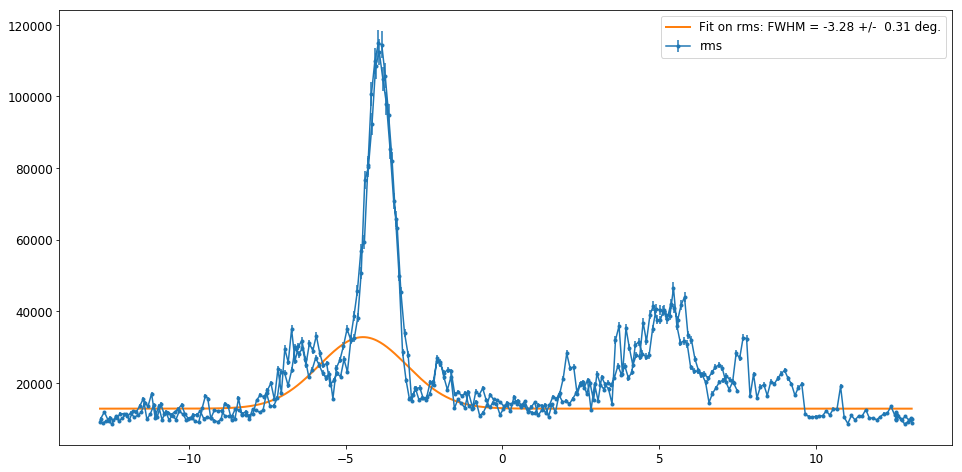

In [257]:
reload(dl)

#### Parameters
ppp = 1./freq_mod
lowcut = 0.1
highcut = 15.
nbins = 100
elevation = 50

t_src = []
data_src = []
angle, sb, dsb, pars, err_pars = dl.general_demodulate(ppp, t_data*1.011, data, t_src, data_src, t_az, az, 
                                                    lowcut, highcut, elevation, 
                                                    nbins=nbins, median=True, method='rms', 
                                                    doplot=True, unbinned=True, 
                                                    renormalize_plot=False)



Now we loop on the TES

In [95]:
reload(dl)
reload(ft)
savedir = '/Volumes/Data/Qubic/Calib-TD/ScanData/'
for ids in xrange(len(datasets)):
    dirs = datasets[ids]
    for ii in xrange(len(dirs)):
        thedir = dirs[ii]
        print '##############################################################'
        print 'Dataset {} / {} :'.format(ids,len(datasets)),names[ids]
        print 'Directory {} / {} :'.format(ii, len(dirs)), thedir
        print '##############################################################'
        alldemod = np.zeros((256,100))
        for iasic in [0,1]:
            print '======== ASIC {} ====================='.format(iasic)
            AsicNum = iasic+1
            a = qp()
            a.read_qubicstudio_dataset(thedir, asic=AsicNum)
            t_data = a.timeline_timeaxis(axistype='index')
            FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
            az = a.azimuth()
            t_az = (np.max(t_data)-np.min(t_data))*np.linspace(0,1,len(az))
            for TESNum in np.arange(128)+1:
                if (16*(TESNum/16))==TESNum: print(TESNum)
                TESindex = iasic*128+(TESNum-1)
                thedata = a.timeline(TES=TESNum)
                t_src=[]
                data_src=[]
                angle, sb, dsb, pars, err_pars = dl.general_demodulate(ppp, t_data, thedata, t_src, data_src, t_az, az, 
                                                            lowcut, highcut, all_elevation[ids][ii], 
                                                            nbins=nbins, median=True, method='rms', 
                                                            doplot=False, unbinned=False)
                alldemod[TESindex,:] = sb
        FitsArray(alldemod).save(savedir+'alltes_{}_el_{}.fits'.format(names[ids],all_elevation[ids][ii]))
        FitsArray(np.append(pars,err_pars).reshape((2,4))).save(savedir+'fitpars_{}_el_{}.fits'.format(names[ids],all_elevation[ids][ii]))


##############################################################
Dataset 0 / 3 : ScanMap
Directory 0 / 41 : /qubic/Data/Calib-TD/2019-03-13/2019-03-13_19.21.34__ScanMap
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-13/2019-03-13_19.21.34__ScanMap/Sums/science-asic1-2019.03.13.192134.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-13/2019-03-13_19.21.34__ScanMap/Sums/science-asic1-2019.03.13.192134.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-13/2019-03-13_19.21.34__ScanMap/Hks/hk-MMR-2019.03.13.193449.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-13/2019-03-13_19.21.34__ScanMap/Hks/hk-MMR-2019.03.13.193449.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-13/2019-03-13_19.21.34__ScanMap/Hks/hk-intern-2019.03.13.192134.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +92216.672854
    c3 = +19033.783517

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +92216.672854
    c3 = +19033.783517

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19033.783517

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +92216.672854
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +194427.703127
    c3 = +46379.630154

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c


Using TES temperature 370.7mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31357.304388
    c3 = +13879.975922

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13879.975922

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31357.304388
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43437.186256
    c3 = +14906.030015

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43437.186256
    c3 = +14906.030015

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35731.759730
    c3 = +22331.525642

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22331.525642

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35731.759730
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18847.154666
    c3 = +15131.267798

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18847.154666
    c3 = +15131.267798

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +76535.358013
    c3 = +13533.874524

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13533.874524

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +76535.358013
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +80812.915796
    c3 = +12994.643111

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +80812.915796
    c3 = +12994.643111

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39164.935941
    c3 = +36476.016644

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +36476.016644

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39164.935941
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +249272.829724
    c3 = +139731.939147

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +249272.829724
    c3 = +139731.939147

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13484.580215
    c3 = +11022.767038

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11022.767038

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13484.580215
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +164025.570523
    c3 = +107401.211491

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +164025.570523
    c3 = +107401.211491

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47862.461599
    c3 = +30994.608317

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +30994.608317

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47862.461599
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35874.385430
    c3 = +22335.732388

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35874.385430
    c3 = +22335.732388

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +53535.319356
    c3 = +34584.174969

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +34584.174969

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53535.319356
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +75423.744577
    c3 = +21338.384498

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +75423.744577
    c3 = +21338.384498

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29163.447619
    c3 = +20820.250486

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20820.250486

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29163.447619
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +225963.806465
    c3 = +39234.370363

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_18.57.13__ScanMapNew2/Sums/science-asic2-2019.03.15.185713.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_18.57.13__ScanMapNew2/Sums/science-asic2-2019.03.15.185713.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_18.57.13__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_18.57.13__ScanMapNew2/Hks/hk-intern-2019.03.15.185713.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_18.57.13__ScanMapNew2/Hks/hk-intern-2019.03.15.185713.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_18.57.13__ScanMapNew2/Hks/conf-asics-2019.03.15.185717.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_18.57.13__ScanMapNew2/Hks/conf-asics-2019.03.15.185717.fits
There are 280 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +225963.806465
    c3 = +39234.370363

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +39234.370363

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +225963.806465
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29403.846029
    c3 = +16048.297795

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29403.846029
    c3 = +16048.297795

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 370.7mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16322.734169
    c3 = +12315.832247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +12315.832247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16322.734169
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +5577.631663
    c3 = +672.948518

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +5577.631663
    c3 = +672.948518

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43319.373872
    c3 = +21523.360997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21523.360997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43319.373872
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +56441.391705
    c3 = +21810.071469

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +56441.391705
    c3 = +21810.071469

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25019.532930
    c3 = +17164.499223

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17164.499223

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25019.532930
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12362.048312
    c3 = +10774.894044

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12362.048312
    c3 = +10774.894044

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +110678.057464
    c3 = +54180.185400

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +54180.185400

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +110678.057464
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37778.825279
    c3 = +19520.738065

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +37778.825279
    c3 = +19520.738065

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +32385.626702
    c3 = +24022.595138

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24022.595138

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +32385.626702
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23313.736755
    c3 = +16181.572116

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23313.736755
    c3 = +16181.572116

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +57580.057964
    c3 = +40124.757340

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40124.757340

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +57580.057964
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +176741.743995
    c3 = +85176.300917

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +176741.743995
    c3 = +85176.300917

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19607.329055
    c3 = +15671.053738

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15671.053738

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19607.329055
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +48504.331727
    c3 = +38336.315565

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +48504.331727
    c3 = +38336.315565

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +61896.492846
    c3 = +29307.340317

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +29307.340317

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +61896.492846
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +30875.161643
    c3 = +21311.850384

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 5 / 41 : /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Sums/science-asic1-2019.03.15.192106.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Sums/science-asic1-2019.03.15.192106.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks/hk-intern-2019.03.15.192106.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks/hk-intern-2019.03.15.192106.fits
reading fits file: /qubic/Data/Calib-TD/2019

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +30875.161643
    c3 = +21311.850384

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21311.850384

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +30875.161643
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +110379.695079
    c3 = +18013.974774

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +110379.695079
    c3 = +18013.974774

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 370.8mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +125798.652504
    c3 = +13880.185891

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13880.185891

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +125798.652504
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27327.195726
    c3 = +16578.603381

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27327.195726
    c3 = +16578.603381

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45522.147156
    c3 = +22495.568847

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22495.568847

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45522.147156
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22209.384651
    c3 = +15632.248268

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22209.384651
    c3 = +15632.248268

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +71113.525783
    c3 = +15146.023510

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15146.023510

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +71113.525783
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +77844.908293
    c3 = +14488.045002

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +77844.908293
    c3 = +14488.045002

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +42925.556451
    c3 = +36462.940089

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +36462.940089

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +42925.556451
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +252636.334745
    c3 = +134716.606539

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +252636.334745
    c3 = +134716.606539

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18482.422242
    c3 = +11310.266961

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11310.266961

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18482.422242
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +174842.157304
    c3 = +118024.382874

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +174842.157304
    c3 = +118024.382874

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +48483.567567
    c3 = +31121.580474

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31121.580474

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +48483.567567
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47778.014781
    c3 = +22753.222198

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47778.014781
    c3 = +22753.222198

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +80405.964268
    c3 = +35823.321348

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +35823.321348

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +80405.964268
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27462.455279
    c3 = +19752.522324

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27462.455279
    c3 = +19752.522324

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29788.912929
    c3 = +21253.379654

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21253.379654

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29788.912929
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +398220.020850
    c3 = +40404.391128

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Sums/science-asic2-2019.03.15.192106.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Sums/science-asic2-2019.03.15.192106.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks/hk-intern-2019.03.15.192106.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks/hk-intern-2019.03.15.192106.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks/conf-asics-2019.03.15.192108.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.21.06__ScanMapNew2/Hks/conf-asics-2019.03.15.192108.fits
There are 286 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +398220.020850
    c3 = +40404.391128

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40404.391128

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +398220.020850
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +48132.675426
    c3 = +17239.067022

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +48132.675426
    c3 = +17239.067022

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 370.8mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18717.429084
    c3 = +11898.984334

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11898.984334

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18717.429084
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +9610.306753
    c3 = +1414.401431

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +9610.306753
    c3 = +1414.401431

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +70489.645299
    c3 = +24989.768449

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24989.768449

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +70489.645299
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +67241.787619
    c3 = +23108.907247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +67241.787619
    c3 = +23108.907247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21701.004376
    c3 = +17671.462168

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17671.462168

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21701.004376
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12886.477348
    c3 = +11060.100343

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12886.477348
    c3 = +11060.100343

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +121803.420460
    c3 = +68219.958333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +68219.958333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +121803.420460
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +56087.402451
    c3 = +20793.715273

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +56087.402451
    c3 = +20793.715273

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29001.859812
    c3 = +24070.617225

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24070.617225

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29001.859812
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25343.181940
    c3 = +16788.862209

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25343.181940
    c3 = +16788.862209

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +73114.651197
    c3 = +38893.826265

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +38893.826265

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +73114.651197
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +164359.807628
    c3 = +81727.895263

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +164359.807628
    c3 = +81727.895263

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21466.071025
    c3 = +15520.256771

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15520.256771

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21466.071025
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +54380.417620
    c3 = +37910.735713

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +54380.417620
    c3 = +37910.735713

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +91176.262560
    c3 = +35239.421109

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +35239.421109

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +91176.262560
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45859.030640
    c3 = +22707.490022

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 6 / 41 : /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Sums/science-asic1-2019.03.15.194527.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Sums/science-asic1-2019.03.15.194527.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks/hk-intern-2019.03.15.194528.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks/hk-intern-2019.03.15.194528.fits
reading fits file: /qubic/Data/Calib-TD/2019

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45859.030640
    c3 = +22707.490022

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22707.490022

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45859.030640
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53381.304437
    c3 = +21158.881133

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +53381.304437
    c3 = +21158.881133

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 370.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23604.162989
    c3 = +13835.398245

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13835.398245

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23604.162989
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29528.943124
    c3 = +16902.120666

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29528.943124
    c3 = +16902.120666

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +46386.219840
    c3 = +21924.902271

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21924.902271

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +46386.219840
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18949.221592
    c3 = +14875.725174

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18949.221592
    c3 = +14875.725174

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +69344.561906
    c3 = +15641.029960

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15641.029960

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +69344.561906
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +74994.055389
    c3 = +13350.664668

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +74994.055389
    c3 = +13350.664668

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +42418.315884
    c3 = +36806.039089

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +36806.039089

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +42418.315884
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +238109.822200
    c3 = +139365.776109

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +238109.822200
    c3 = +139365.776109

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +15102.474765
    c3 = +11149.957051

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11149.957051

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +15102.474765
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +167049.265864
    c3 = +126473.713321

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +167049.265864
    c3 = +126473.713321

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50035.174186
    c3 = +30770.074560

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +30770.074560

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50035.174186
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27619.926044
    c3 = +22092.439396

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27619.926044
    c3 = +22092.439396

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +85817.373897
    c3 = +42081.401442

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +42081.401442

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +85817.373897
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24681.890384
    c3 = +19366.116088

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24681.890384
    c3 = +19366.116088

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29368.111467
    c3 = +20662.712997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20662.712997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29368.111467
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +271427.736498
    c3 = +40215.962045

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Sums/science-asic2-2019.03.15.194527.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Sums/science-asic2-2019.03.15.194527.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks/hk-intern-2019.03.15.194528.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks/hk-intern-2019.03.15.194528.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks/conf-asics-2019.03.15.194529.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_19.45.27__ScanMapNew2/Hks/conf-asics-2019.03.15.194529.fits
There are 279 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +271427.736498
    c3 = +40215.962045

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40215.962045

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +271427.736498
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35378.248869
    c3 = +16890.508834

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35378.248869
    c3 = +16890.508834

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 370.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18108.432204
    c3 = +13203.754293

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13203.754293

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18108.432204
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +5672.119147
    c3 = +1064.982611

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +5672.119147
    c3 = +1064.982611

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50176.913700
    c3 = +23684.446587

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23684.446587

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50176.913700
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +48716.685184
    c3 = +25114.972098

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +48716.685184
    c3 = +25114.972098

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23767.230640
    c3 = +17486.636592

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17486.636592

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23767.230640
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12369.864061
    c3 = +10848.077704

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12369.864061
    c3 = +10848.077704

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +110976.234962
    c3 = +68169.072333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +68169.072333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +110976.234962
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36683.348898
    c3 = +20366.180529

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36683.348898
    c3 = +20366.180529

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27138.726926
    c3 = +24256.279536

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24256.279536

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27138.726926
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23013.311938
    c3 = +17693.353387

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23013.311938
    c3 = +17693.353387

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +67582.836827
    c3 = +40191.564715

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40191.564715

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +67582.836827
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +147800.974708
    c3 = +77632.419883

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +147800.974708
    c3 = +77632.419883

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19390.268708
    c3 = +15485.247485

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15485.247485

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19390.268708
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53292.492628
    c3 = +26983.413484

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +53292.492628
    c3 = +26983.413484

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +66978.214664
    c3 = +29201.896654

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +29201.896654

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +66978.214664
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36580.191260
    c3 = +21576.362500

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 7 / 41 : /qubic/Data/Calib-TD/2019-03-15/2019-03-15_20.09.12__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_20.09.12__ScanMapNew2/Sums/science-asic1-2019.03.15.200912.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_20.09.12__ScanMapNew2/Sums/science-asic1-2019.03.15.200912.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_20.09.12__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_20.09.12__ScanMapNew2/Hks/hk-intern-2019.03.15.200912.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_20.09.12__ScanMapNew2/Hks/hk-intern-2019.03.15.200912.fits
reading fits file: /qubic/Data/Calib-TD/2019

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36580.191260
    c3 = +21576.362500

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21576.362500

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36580.191260
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +66991.578069
    c3 = +30547.844420

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +66991.578069
    c3 = +30547.844420

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 371.3mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22446.960654
    c3 = +13805.419421

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13805.419421

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22446.960654
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25388.753665
    c3 = +18665.650170

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25388.753665
    c3 = +18665.650170

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35281.189040
    c3 = +25155.567121

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25155.567121

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35281.189040
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21897.221472
    c3 = +17226.406250

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21897.221472
    c3 = +17226.406250

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +26244.798466
    c3 = +15696.343333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15696.343333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +26244.798466
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +88022.383355
    c3 = +20224.558774

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +88022.383355
    c3 = +20224.558774

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41534.833948
    c3 = +37430.783622

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +37430.783622

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41534.833948
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +226255.648180
    c3 = +126839.459528

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +226255.648180
    c3 = +126839.459528

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16440.912387
    c3 = +12925.777920

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +12925.777920

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16440.912387
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +365335.513847
    c3 = +104791.873439

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +365335.513847
    c3 = +104791.873439

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +46152.402884
    c3 = +29286.830719

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +29286.830719

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +46152.402884
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25209.504725
    c3 = +20598.048436

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25209.504725
    c3 = +20598.048436

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +373031.821217
    c3 = +34765.361700

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +34765.361700

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +373031.821217
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +119401.118870
    c3 = +24280.592864

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +119401.118870
    c3 = +24280.592864

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29872.718253
    c3 = +20418.224266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20418.224266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29872.718253
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +313267.362634
    c3 = +39592.403570

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_22.56.22__ScanMapNew2/Sums/science-asic2-2019.03.15.225622.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_22.56.22__ScanMapNew2/Sums/science-asic2-2019.03.15.225622.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_22.56.22__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_22.56.22__ScanMapNew2/Hks/hk-intern-2019.03.15.225623.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_22.56.22__ScanMapNew2/Hks/hk-intern-2019.03.15.225623.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_22.56.22__ScanMapNew2/Hks/conf-asics-2019.03.15.225624.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_22.56.22__ScanMapNew2/Hks/conf-asics-2019.03.15.225624.fits
There are 286 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +313267.362634
    c3 = +39592.403570

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +39592.403570

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +313267.362634
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +30415.315295
    c3 = +15792.883206

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +30415.315295
    c3 = +15792.883206

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 371.3mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20131.922587
    c3 = +11736.779927

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11736.779927

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20131.922587
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23589.004805
    c3 = +56.359078

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23589.004805
    c3 = +56.359078

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45420.868973
    c3 = +22503.488341

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22503.488341

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45420.868973
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +66556.877061
    c3 = +22373.589275

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +66556.877061
    c3 = +22373.589275

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22725.366637
    c3 = +14904.739875

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14904.739875

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22725.366637
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12762.983425
    c3 = +11217.959162

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12762.983425
    c3 = +11217.959162

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +240703.853911
    c3 = +26963.063290

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26963.063290

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +240703.853911
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +99147.062938
    c3 = +20719.252402

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +99147.062938
    c3 = +20719.252402

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34349.468971
    c3 = +27032.382870

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +27032.382870

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34349.468971
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18343.704451
    c3 = +15422.019256

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18343.704451
    c3 = +15422.019256

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +55493.524610
    c3 = +34081.140139

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +34081.140139

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +55493.524610
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +96900.568631
    c3 = +64031.926125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +96900.568631
    c3 = +64031.926125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18548.927135
    c3 = +16479.961864

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +16479.961864

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18548.927135
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +28048.947557
    c3 = +18919.404189

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +28048.947557
    c3 = +18919.404189

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +60028.087359
    c3 = +25145.156208

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25145.156208

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +60028.087359
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37572.616422
    c3 = +24221.735459

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 15 / 41 : /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.20.43__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.20.43__ScanMapNew2/Sums/science-asic1-2019.03.15.232043.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.20.43__ScanMapNew2/Sums/science-asic1-2019.03.15.232043.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.20.43__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.20.43__ScanMapNew2/Hks/hk-intern-2019.03.15.232043.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.20.43__ScanMapNew2/Hks/hk-intern-2019.03.15.232043.fits
reading fits file: /qubic/Data/Calib-TD/201

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +37572.616422
    c3 = +24221.735459

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24221.735459

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37572.616422
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +67177.114360
    c3 = +33185.439574

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +67177.114360
    c3 = +33185.439574

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 371.4mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22954.616821
    c3 = +13766.551554

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13766.551554

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22954.616821
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +57798.146202
    c3 = +19151.081795

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +57798.146202
    c3 = +19151.081795

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +40264.604947
    c3 = +27201.909426

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +27201.909426

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +40264.604947
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23599.313530
    c3 = +19025.463306

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23599.313530
    c3 = +19025.463306

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +63428.265811
    c3 = +10949.502865

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +10949.502865

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +63428.265811
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +116935.841888
    c3 = +14392.734962

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +116935.841888
    c3 = +14392.734962

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +128255.013160
    c3 = +37218.083538

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +37218.083538

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +128255.013160
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +305595.747643
    c3 = +144356.087483

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +305595.747643
    c3 = +144356.087483

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000



80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +14111.288189
    c3 = +11224.603697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11224.603697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +14111.288189
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +144652.126595
    c3 = +103972.158577

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +144652.126595
    c3 = +103972.158577

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +38739.564718
    c3 = +31152.300152

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31152.300152

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +38739.564718
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44058.950524
    c3 = +22127.842086

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44058.950524
    c3 = +22127.842086

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +119019.481494
    c3 = +32319.557904

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32319.557904

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +119019.481494
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31967.816852
    c3 = +21030.034203

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31967.816852
    c3 = +21030.034203

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25515.196305
    c3 = +21170.363261

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21170.363261

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25515.196305
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +379558.051927
    c3 = +39751.965277

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.44.26__ScanMapNew2/Sums/science-asic2-2019.03.15.234426.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.44.26__ScanMapNew2/Sums/science-asic2-2019.03.15.234426.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.44.26__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.44.26__ScanMapNew2/Hks/hk-intern-2019.03.15.234427.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.44.26__ScanMapNew2/Hks/hk-intern-2019.03.15.234427.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.44.26__ScanMapNew2/Hks/conf-asics-2019.03.15.234427.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_23.44.26__ScanMapNew2/Hks/conf-asics-2019.03.15.234427.fits
There are 280 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +379558.051927
    c3 = +39751.965277

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +39751.965277

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +379558.051927
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27061.688916
    c3 = +14631.030957

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27061.688916
    c3 = +14631.030957

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 371.4mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16710.714874
    c3 = +12103.361894

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +12103.361894

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16710.714874
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +33431.866259
    c3 = +653.746289

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +33431.866259
    c3 = +653.746289

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45382.458375
    c3 = +20153.924074

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20153.924074

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45382.458375
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +54816.394712
    c3 = +20664.288089

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +54816.394712
    c3 = +20664.288089

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18500.831748
    c3 = +15685.483507

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15685.483507

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18500.831748
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12926.155218
    c3 = +10650.426855

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12926.155218
    c3 = +10650.426855

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36677.826461
    c3 = +19833.016668

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19833.016668

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36677.826461
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36781.196912
    c3 = +18734.781947

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36781.196912
    c3 = +18734.781947

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35520.449553
    c3 = +26076.793811

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26076.793811

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35520.449553
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19575.975372
    c3 = +16143.635475

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19575.975372
    c3 = +16143.635475

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50093.220425
    c3 = +33880.090017

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +33880.090017

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50093.220425
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +109520.067333
    c3 = +61769.892920

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +109520.067333
    c3 = +61769.892920

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27021.674299
    c3 = +15556.155400

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15556.155400

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27021.674299
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +51576.435199
    c3 = +36743.893755

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +51576.435199
    c3 = +36743.893755

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +53806.928383
    c3 = +23481.262300

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23481.262300

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53806.928383
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36562.554950
    c3 = +20522.600497

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 17 / 41 : /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Sums/science-asic1-2019.03.16.000820.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Sums/science-asic1-2019.03.16.000820.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks/hk-intern-2019.03.16.000820.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks/hk-intern-2019.03.16.000820.fits
reading fits file: /qubic/Data/Calib-TD/201

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36562.554950
    c3 = +20522.600497

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20522.600497

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36562.554950
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +71647.025014
    c3 = +29742.173153

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +71647.025014
    c3 = +29742.173153

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 371.1mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19679.979924
    c3 = +12898.562920

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +12898.562920

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19679.979924
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23967.894564
    c3 = +18671.044961

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23967.894564
    c3 = +18671.044961

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36219.709441
    c3 = +26848.065166

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26848.065166

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36219.709441
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25209.024344
    c3 = +18984.282323

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25209.024344
    c3 = +18984.282323

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +165070.048481
    c3 = +8982.358573

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +8982.358573

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +165070.048481
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +160109.676706
    c3 = +8986.992991

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +160109.676706
    c3 = +8986.992991

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +111591.937230
    c3 = +36996.954603

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +36996.954603

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +111591.937230
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +279942.405242
    c3 = +142955.561410

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +279942.405242
    c3 = +142955.561410

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000



80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13667.491466
    c3 = +11297.159636

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11297.159636

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13667.491466
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +136749.543280
    c3 = +102221.864737

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +136749.543280
    c3 = +102221.864737

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47060.434202
    c3 = +31211.673831

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31211.673831

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47060.434202
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27098.606049
    c3 = +21954.138644

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27098.606049
    c3 = +21954.138644

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +65627.025926
    c3 = +26477.994094

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26477.994094

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +65627.025926
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25650.262930
    c3 = +19357.502628

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25650.262930
    c3 = +19357.502628

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +28743.965078
    c3 = +21180.184445

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21180.184445

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +28743.965078
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +204178.375458
    c3 = +39867.732616

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Sums/science-asic2-2019.03.16.000820.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Sums/science-asic2-2019.03.16.000820.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks/hk-intern-2019.03.16.000820.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks/hk-intern-2019.03.16.000820.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks/conf-asics-2019.03.16.000823.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.08.20__ScanMapNew2/Hks/conf-asics-2019.03.16.000823.fits
There are 280 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +204178.375458
    c3 = +39867.732616

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +39867.732616

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +204178.375458
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +28359.513543
    c3 = +13949.859188

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +28359.513543
    c3 = +13949.859188

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 371.1mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16963.382255
    c3 = +12414.833378

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +12414.833378

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16963.382255
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35014.487579
    c3 = +1199.666302

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35014.487579
    c3 = +1199.666302

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +40754.679242
    c3 = +18942.242125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18942.242125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +40754.679242
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +61102.536678
    c3 = +19972.267285

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +61102.536678
    c3 = +19972.267285

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18553.418340
    c3 = +14970.455232

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14970.455232

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18553.418340
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12671.347584
    c3 = +10586.553840

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12671.347584
    c3 = +10586.553840

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36935.056373
    c3 = +19507.207889

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19507.207889

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36935.056373
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +33385.583660
    c3 = +17886.255332

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +33385.583660
    c3 = +17886.255332

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35146.842070
    c3 = +25749.362273

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25749.362273

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35146.842070
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47844.627443
    c3 = +16166.142939

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47844.627443
    c3 = +16166.142939

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +51650.794680
    c3 = +33126.715437

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +33126.715437

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +51650.794680
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +209014.478249
    c3 = +62052.126542

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +209014.478249
    c3 = +62052.126542

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20519.314358
    c3 = +14757.005570

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14757.005570

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20519.314358
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45638.982500
    c3 = +34191.875409

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45638.982500
    c3 = +34191.875409

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +49212.598949
    c3 = +22172.574771

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22172.574771

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +49212.598949
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31720.767712
    c3 = +19939.817069

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 18 / 41 : /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.32.14__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.32.14__ScanMapNew2/Sums/science-asic1-2019.03.16.003214.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.32.14__ScanMapNew2/Sums/science-asic1-2019.03.16.003214.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.32.14__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.32.14__ScanMapNew2/Hks/hk-intern-2019.03.16.003214.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_00.32.14__ScanMapNew2/Hks/hk-intern-2019.03.16.003214.fits
reading fits file: /qubic/Data/Calib-TD/201

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31720.767712
    c3 = +19939.817069

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19939.817069

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31720.767712
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +89501.672682
    c3 = +38778.420516

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +89501.672682
    c3 = +38778.420516

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 371.6mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45882.983470
    c3 = +13469.087301

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13469.087301

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45882.983470
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39362.372349
    c3 = +18759.992593

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39362.372349
    c3 = +18759.992593

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +73927.486340
    c3 = +26789.945370

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26789.945370

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +73927.486340
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25758.781458
    c3 = +21221.372643

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25758.781458
    c3 = +21221.372643

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +60617.835717
    c3 = +2069.263074

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +2069.263074

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +60617.835717
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +141534.490748
    c3 = +7321.404177

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +141534.490748
    c3 = +7321.404177

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +115824.316130
    c3 = +41167.574839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +41167.574839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +115824.316130
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +973886.564383
    c3 = +144760.980489

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +973886.564383
    c3 = +144760.980489

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000



80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +15510.906352
    c3 = +11326.144359

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11326.144359

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +15510.906352
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +156150.792064
    c3 = +91604.350064

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +156150.792064
    c3 = +91604.350064

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47208.186003
    c3 = +31715.958498

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31715.958498

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47208.186003
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45455.536718
    c3 = +21356.716612

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45455.536718
    c3 = +21356.716612

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +174878.487388
    c3 = +31591.568386

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31591.568386

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +174878.487388
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +137877.866898
    c3 = +19173.879440

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +137877.866898
    c3 = +19173.879440

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +28805.992314
    c3 = +20566.889934

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20566.889934

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +28805.992314
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +270225.043795
    c3 = +38936.289897

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_01.43.54__ScanMapNew2/Sums/science-asic2-2019.03.16.014354.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_01.43.54__ScanMapNew2/Sums/science-asic2-2019.03.16.014354.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_01.43.54__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_01.43.54__ScanMapNew2/Hks/hk-intern-2019.03.16.014354.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_01.43.54__ScanMapNew2/Hks/hk-intern-2019.03.16.014354.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_01.43.54__ScanMapNew2/Hks/conf-asics-2019.03.16.014358.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_01.43.54__ScanMapNew2/Hks/conf-asics-2019.03.16.014358.fits
There are 278 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +270225.043795
    c3 = +38936.289897

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +38936.289897

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +270225.043795
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23122.156758
    c3 = +12811.342654

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23122.156758
    c3 = +12811.342654

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 371.6mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +15718.502191
    c3 = +13328.434463

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13328.434463

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +15718.502191
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +545584.532900
    c3 = +20068.799484

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +545584.532900
    c3 = +20068.799484

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34826.932476
    c3 = +16552.635817

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +16552.635817

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34826.932476
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +102516.120504
    c3 = +16376.813260

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +102516.120504
    c3 = +16376.813260

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18408.905076
    c3 = +14987.869762

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14987.869762

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18408.905076
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21815.524787
    c3 = +12141.636547

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21815.524787
    c3 = +12141.636547

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +61232.788005
    c3 = +17488.000275

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17488.000275

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +61232.788005
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +26960.192781
    c3 = +14175.873644

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +26960.192781
    c3 = +14175.873644

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +26943.953257
    c3 = +25344.914372

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25344.914372

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +26943.953257
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17617.963054
    c3 = +15875.175292

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17617.963054
    c3 = +15875.175292

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +54473.255327
    c3 = +31150.993190

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31150.993190

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +54473.255327
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +224603.066637
    c3 = +61802.629252

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +224603.066637
    c3 = +61802.629252

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +26265.947487
    c3 = +15996.861984

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15996.861984

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +26265.947487
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +54020.780049
    c3 = +42859.998324

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +54020.780049
    c3 = +42859.998324

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50963.857480
    c3 = +23175.051062

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23175.051062

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50963.857480
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31910.134163
    c3 = +19007.199470

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 22 / 41 : /qubic/Data/Calib-TD/2019-03-16/2019-03-16_02.07.36__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_02.07.36__ScanMapNew2/Sums/science-asic1-2019.03.16.020736.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_02.07.36__ScanMapNew2/Sums/science-asic1-2019.03.16.020736.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_02.07.36__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_02.07.36__ScanMapNew2/Hks/hk-intern-2019.03.16.020736.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_02.07.36__ScanMapNew2/Hks/hk-intern-2019.03.16.020736.fits
reading fits file: /qubic/Data/Calib-TD/201

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31910.134163
    c3 = +19007.199470

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19007.199470

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31910.134163
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +80842.143148
    c3 = +26550.773721

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +80842.143148
    c3 = +26550.773721

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 372.2mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21247.258360
    c3 = +9642.780721

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +9642.780721

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21247.258360
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22028.329966
    c3 = +17609.711697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22028.329966
    c3 = +17609.711697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43093.060505
    c3 = +24622.237966

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24622.237966

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43093.060505
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24452.356848
    c3 = +19341.575131

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24452.356848
    c3 = +19341.575131

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +196110.747413
    c3 = +7504.860452

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +7504.860452

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +196110.747413
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +101021.382703
    c3 = +3123.621776

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +101021.382703
    c3 = +3123.621776

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41388.498927
    c3 = +36814.102131

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +36814.102131

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41388.498927
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +262259.160799
    c3 = +157119.418542

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +262259.160799
    c3 = +157119.418542

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13903.473003
    c3 = +10848.577887

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +10848.577887

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13903.473003
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +131268.452846
    c3 = +76118.710017

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +131268.452846
    c3 = +76118.710017

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +40223.512654
    c3 = +32416.889738

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32416.889738

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +40223.512654
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +30613.938517
    c3 = +21666.874970

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +30613.938517
    c3 = +21666.874970

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +62906.304824
    c3 = +23419.036957

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23419.036957

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +62906.304824
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +70698.540617
    c3 = +19106.023811

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +70698.540617
    c3 = +19106.023811

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27686.431129
    c3 = +20611.903047

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20611.903047

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27686.431129
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +46883.711403
    c3 = +38775.354295

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.06.16__ScanMapNew2/Sums/science-asic2-2019.03.16.080616.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.06.16__ScanMapNew2/Sums/science-asic2-2019.03.16.080616.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.06.16__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.06.16__ScanMapNew2/Hks/hk-intern-2019.03.16.080617.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.06.16__ScanMapNew2/Hks/hk-intern-2019.03.16.080617.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.06.16__ScanMapNew2/Hks/conf-asics-2019.03.16.080617.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.06.16__ScanMapNew2/Hks/conf-asics-2019.03.16.080617.fits
There are 281 housekeeping

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +46883.711403
    c3 = +38775.354295

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +38775.354295

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +46883.711403
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +40260.901603
    c3 = +17498.349110

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +40260.901603
    c3 = +17498.349110

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 372.2mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13187.927799
    c3 = +11251.087501

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11251.087501

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13187.927799
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21480.033057
    c3 = +984.851086

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21480.033057
    c3 = +984.851086

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +65715.392785
    c3 = +26241.177583

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26241.177583

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +65715.392785
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +105457.847837
    c3 = +29426.407858

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +105457.847837
    c3 = +29426.407858

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19448.912350
    c3 = +14709.089446

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14709.089446

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19448.912350
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13812.906881
    c3 = +11580.671061

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13812.906881
    c3 = +11580.671061

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +52813.806364
    c3 = +22183.350765

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22183.350765

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +52813.806364
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +56058.511574
    c3 = +22049.208419

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +56058.511574
    c3 = +22049.208419

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34272.613128
    c3 = +29243.528802

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +29243.528802

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34272.613128
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19814.739975
    c3 = +16008.747810

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19814.739975
    c3 = +16008.747810

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +68244.084363
    c3 = +34961.959647

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +34961.959647

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +68244.084363
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +121736.699440
    c3 = +80282.743527

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +121736.699440
    c3 = +80282.743527

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16479.565512
    c3 = +14252.325673

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14252.325673

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16479.565512
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +33845.300142
    c3 = +27173.455827

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +33845.300142
    c3 = +27173.455827

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50696.110416
    c3 = +24394.605224

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24394.605224

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50696.110416
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53407.528310
    c3 = +23684.825963

  m.migrad()



##############################################################
Dataset 1 / 3 : ScanMapNew2
Directory 38 / 41 : /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.30.10__ScanMapNew2
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.30.10__ScanMapNew2/Sums/science-asic1-2019.03.16.083010.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.30.10__ScanMapNew2/Sums/science-asic1-2019.03.16.083010.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.30.10__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.30.10__ScanMapNew2/Hks/hk-intern-2019.03.16.083010.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_08.30.10__ScanMapNew2/Hks/hk-intern-2019.03.16.083010.fits
reading fits file: /qubic/Data/Calib-TD/201

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +53407.528310
    c3 = +23684.825963

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23684.825963

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53407.528310
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +83064.715321
    c3 = +26699.410479

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +83064.715321
    c3 = +26699.410479

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 370.3mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +68691.090575
    c3 = +11547.825192

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11547.825192

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +68691.090575
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24907.588967
    c3 = +20104.543969

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24907.588967
    c3 = +20104.543969

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39148.598625
    c3 = +25217.004688

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25217.004688

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39148.598625
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22849.884465
    c3 = +18629.133185

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22849.884465
    c3 = +18629.133185

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21451.149416
    c3 = +13609.663610

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13609.663610

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21451.149416
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +98911.021511
    c3 = +4526.079877

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +98911.021511
    c3 = +4526.079877

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +37895.337221
    c3 = +35512.001436

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +35512.001436

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37895.337221
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +222076.967915
    c3 = +123451.390913

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +222076.967915
    c3 = +123451.390913

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13649.131853
    c3 = +11418.493020

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11418.493020

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13649.131853
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +181824.215587
    c3 = +121319.697976

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +181824.215587
    c3 = +121319.697976

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41825.518460
    c3 = +30997.071494

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +30997.071494

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41825.518460
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44887.673745
    c3 = +19366.226023

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44887.673745
    c3 = +19366.226023

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +48010.006474
    c3 = +26009.866915

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26009.866915

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +48010.006474
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +144361.269677
    c3 = +27149.886578

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +144361.269677
    c3 = +27149.886578

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25983.493486
    c3 = +19388.285907

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19388.285907

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25983.493486
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47115.766253
    c3 = +37384.510191

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.17.20__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.16.201720.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.17.20__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.16.201720.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.17.20__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.17.20__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.201720.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.17.20__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.201720.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.17.20__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.16.201721.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.17.20__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47115.766253
    c3 = +37384.510191

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +37384.510191

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47115.766253
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +28079.252540
    c3 = +14235.354261

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +28079.252540
    c3 = +14235.354261

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 370.3mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13716.904315
    c3 = +10315.039269

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +10315.039269

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13716.904315
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +10403.958621
    c3 = +7081.679941

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +10403.958621
    c3 = +7081.679941

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44570.252057
    c3 = +18503.789976

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18503.789976

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44570.252057
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50942.151635
    c3 = +18009.045300

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50942.151635
    c3 = +18009.045300

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21091.983649
    c3 = +14257.297131

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14257.297131

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21091.983649
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +11756.947820
    c3 = +10754.549793

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +11756.947820
    c3 = +10754.549793

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +51107.643456
    c3 = +29003.778402

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +29003.778402

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +51107.643456
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36325.555244
    c3 = +17536.927460

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36325.555244
    c3 = +17536.927460

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35216.184378
    c3 = +24376.628667

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24376.628667

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35216.184378
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21482.746782
    c3 = +14734.815312

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21482.746782
    c3 = +14734.815312

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +71146.002690
    c3 = +45302.885117

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +45302.885117

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +71146.002690
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +175478.805581
    c3 = +105646.809141

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +175478.805581
    c3 = +105646.809141

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24463.534916
    c3 = +14827.049421

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14827.049421

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24463.534916
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27320.602212
    c3 = +21381.075614

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27320.602212
    c3 = +21381.075614

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +57423.194358
    c3 = +30846.972374

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +30846.972374

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +57423.194358
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27424.271914
    c3 = +19249.645276

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 1 / 41 : /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.41.13__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.41.13__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.16.204113.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.41.13__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.16.204113.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.41.13__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.41.13__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.204113.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_20.41.13__ScanMapNew2_start-40.5/Hks/

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27424.271914
    c3 = +19249.645276

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19249.645276

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27424.271914
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +68302.035882
    c3 = +28205.153902

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +68302.035882
    c3 = +28205.153902

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 370.0mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43463.970959
    c3 = +9963.878168

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +9963.878168

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43463.970959
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24717.775611
    c3 = +19404.283291

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24717.775611
    c3 = +19404.283291

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +40434.519602
    c3 = +25210.835701

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25210.835701

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +40434.519602
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24633.435975
    c3 = +19877.235573

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24633.435975
    c3 = +19877.235573

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18652.003415
    c3 = +13981.119138

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13981.119138

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18652.003415
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +101065.510227
    c3 = +5346.008501

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +101065.510227
    c3 = +5346.008501

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43828.974169
    c3 = +35011.131449

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +35011.131449

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43828.974169
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +250015.060791
    c3 = +131188.803101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +250015.060791
    c3 = +131188.803101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13886.742832
    c3 = +11236.874229

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11236.874229

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13886.742832
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +147533.334443
    c3 = +109056.926345

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +147533.334443
    c3 = +109056.926345

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +40454.049037
    c3 = +30638.750685

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +30638.750685

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +40454.049037
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44980.552127
    c3 = +20109.730727

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44980.552127
    c3 = +20109.730727

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +63626.085219
    c3 = +31437.494581

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31437.494581

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +63626.085219
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +168734.103130
    c3 = +36644.502183

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +168734.103130
    c3 = +36644.502183

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25647.983980
    c3 = +19198.276927

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19198.276927

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25647.983980
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +218617.885943
    c3 = +37185.213888

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.29.17__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.16.212917.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.29.17__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.16.212917.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.29.17__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.29.17__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.212917.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.29.17__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.212917.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.29.17__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.16.212919.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.29.17__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +218617.885943
    c3 = +37185.213888

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +37185.213888

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +218617.885943
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24302.148279
    c3 = +14870.183077

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24302.148279
    c3 = +14870.183077

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 370.0mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12703.393532
    c3 = +11205.689868

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11205.689868

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12703.393532
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13137.594470
    c3 = +4003.354101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13137.594470
    c3 = +4003.354101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34098.675097
    c3 = +19886.425162

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19886.425162

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34098.675097
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50160.052154
    c3 = +19851.776772

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50160.052154
    c3 = +19851.776772

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17334.677504
    c3 = +13324.271429

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13324.271429

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17334.677504
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12903.384653
    c3 = +10629.123888

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12903.384653
    c3 = +10629.123888

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +142055.971188
    c3 = +42458.042415

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +42458.042415

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +142055.971188
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36651.550528
    c3 = +17672.644585

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36651.550528
    c3 = +17672.644585

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31798.079528
    c3 = +22749.439534

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22749.439534

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31798.079528
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21848.282809
    c3 = +15336.473839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21848.282809
    c3 = +15336.473839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +73221.533795
    c3 = +43626.999629

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +43626.999629

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +73221.533795
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +211229.099574
    c3 = +99783.559471

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +211229.099574
    c3 = +99783.559471

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16937.536284
    c3 = +14048.874987

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14048.874987

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16937.536284
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31036.169677
    c3 = +3804.144039

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31036.169677
    c3 = +3804.144039

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +58569.974147
    c3 = +30126.162553

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +30126.162553

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +58569.974147
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29138.458411
    c3 = +19141.670522

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 4 / 41 : /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.53.47__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.53.47__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.16.215347.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.53.47__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.16.215347.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.53.47__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.53.47__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.215425.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_21.53.47__ScanMapNew2_start-40.5/Hks/

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29138.458411
    c3 = +19141.670522

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19141.670522

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29138.458411
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +252973.673660
    c3 = +41446.602729

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +252973.673660
    c3 = +41446.602729

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 369.6mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +77239.893693
    c3 = +13363.188049

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13363.188049

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +77239.893693
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +29030.077138
    c3 = +18595.944200

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +29030.077138
    c3 = +18595.944200

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34958.218560
    c3 = +25464.875092

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25464.875092

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34958.218560
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25727.989081
    c3 = +22351.395448

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25727.989081
    c3 = +22351.395448

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17957.143102
    c3 = +14514.370199

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14514.370199

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17957.143102
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +117475.561778
    c3 = +11296.223548

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +117475.561778
    c3 = +11296.223548

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +68453.750383
    c3 = +36718.042155

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +36718.042155

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +68453.750383
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +185070.556065
    c3 = +118423.245414

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +185070.556065
    c3 = +118423.245414

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +14705.566815
    c3 = +11532.469431

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11532.469431

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +14705.566815
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +159810.951778
    c3 = +92444.849341

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +159810.951778
    c3 = +92444.849341

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39308.749510
    c3 = +30654.660930

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +30654.660930

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39308.749510
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24137.984451
    c3 = +20561.467325

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24137.984451
    c3 = +20561.467325

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +146173.868460
    c3 = +24822.595697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24822.595697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +146173.868460
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +133656.953852
    c3 = +23919.142706

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +133656.953852
    c3 = +23919.142706

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +26949.901922
    c3 = +19654.222975

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19654.222975

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +26949.901922
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +195315.052330
    c3 = +37199.902801

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.29.20__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.16.232920.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.29.20__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.16.232920.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.29.20__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.29.20__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.232920.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.29.20__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.232920.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.29.20__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.16.232921.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.29.20__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +195315.052330
    c3 = +37199.902801

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +37199.902801

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +195315.052330
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +30951.134231
    c3 = +14937.804910

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +30951.134231
    c3 = +14937.804910

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 369.6mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20380.203130
    c3 = +15042.923351

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15042.923351

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20380.203130
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1552.288346
    c3 = +439.936317

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +1552.288346
    c3 = +439.936317

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47330.907973
    c3 = +20197.143820

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20197.143820

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47330.907973
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50335.447422
    c3 = +20284.171172

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50335.447422
    c3 = +20284.171172

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18558.961527
    c3 = +13304.939683

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13304.939683

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18558.961527
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13473.885287
    c3 = +11109.387144

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13473.885287
    c3 = +11109.387144

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +112675.440211
    c3 = +60072.559186

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +60072.559186

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +112675.440211
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39689.847241
    c3 = +18923.412126

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39689.847241
    c3 = +18923.412126

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34000.098821
    c3 = +23941.911326

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23941.911326

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34000.098821
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18478.307775
    c3 = +15212.583208

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18478.307775
    c3 = +15212.583208

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +60010.665793
    c3 = +40678.660529

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40678.660529

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +60010.665793
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +136241.546336
    c3 = +70212.691332

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +136241.546336
    c3 = +70212.691332

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24604.672493
    c3 = +17264.985817

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17264.985817

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24604.672493
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +49887.765505
    c3 = +35588.727662

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +49887.765505
    c3 = +35588.727662

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +58314.451651
    c3 = +26568.954648

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26568.954648

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +58314.451651
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37528.123202
    c3 = +20072.691839

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 9 / 41 : /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.53.15__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.53.15__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.16.235315.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.53.15__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.16.235315.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.53.15__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.53.15__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.16.235315.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-16/2019-03-16_23.53.15__ScanMapNew2_start-40.5/Hks/

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +37528.123202
    c3 = +20072.691839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +20072.691839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37528.123202
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22413.364797
    c3 = +3406.036118

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22413.364797
    c3 = +3406.036118

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


Using TES temperature 369.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43884.671620
    c3 = +6878.366209

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +6878.366209

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43884.671620
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +83988.696352
    c3 = +19522.893403

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +83988.696352
    c3 = +19522.893403

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +32330.653655
    c3 = +17972.915657

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17972.915657

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +32330.653655
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +127471.621900
    c3 = +17758.858251

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +127471.621900
    c3 = +17758.858251

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22903.361552
    c3 = +15707.650446

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15707.650446

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22903.361552
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +79884.347529
    c3 = +1680.507731

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +79884.347529
    c3 = +1680.507731

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +67971.708705
    c3 = +37276.261855

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +37276.261855

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +67971.708705
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +963303.640204
    c3 = +161070.528754

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +963303.640204
    c3 = +161070.528754

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16156.714042
    c3 = +11907.038322

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11907.038322

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16156.714042
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +183562.079391
    c3 = +91630.114743

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +183562.079391
    c3 = +91630.114743

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45936.991058
    c3 = +32557.721343

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32557.721343

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45936.991058
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +33770.243528
    c3 = +21178.818946

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +33770.243528
    c3 = +21178.818946

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +157975.862138
    c3 = +6159.305286

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +6159.305286

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +157975.862138
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +112961.623768
    c3 = +21778.947568

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +112961.623768
    c3 = +21778.947568

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25659.649086
    c3 = +18759.311926

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18759.311926

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25659.649086
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +143728.453443
    c3 = +33758.977015

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.16.17__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.041617.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.16.17__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.041617.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.16.17__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.16.17__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.041617.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.16.17__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.041617.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.16.17__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.17.041618.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.16.17__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +143728.453443
    c3 = +33758.977015

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +33758.977015

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +143728.453443
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13343.143235
    c3 = +10230.119438

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13343.143235
    c3 = +10230.119438

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 369.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +32330.422261
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +32330.422261
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17645.109127
    c3 = +7010.523094

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17645.109127
    c3 = +7010.523094

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +7010.523094

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +176


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21027.541965
    c3 = +13209.528855

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13209.528855

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21027.541965
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19355.905829
    c3 = +70.258951

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19355.905829
    c3 = +70.258951

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17061.293005
    c3 = +11373.985298

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11373.985298

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17061.293005
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12693.880912
    c3 = +10690.441829

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12693.880912
    c3 = +10690.441829

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +109404.065970
    c3 = +13110.670859

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13110.670859

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +109404.065970
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +14300.128681
    c3 = +11247.130997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +14300.128681
    c3 = +11247.130997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27582.188088
    c3 = +25285.902260

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25285.902260

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27582.188088
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +15643.979419
    c3 = +13516.506918

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +15643.979419
    c3 = +13516.506918

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +46040.823838
    c3 = +28264.171316

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +28264.171316

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +46040.823838
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +113144.614104
    c3 = +70307.126313

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +113144.614104
    c3 = +70307.126313

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20899.637798
    c3 = +18913.956974

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18913.956974

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20899.637798
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22880.236467
    c3 = +18105.631904

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22880.236467
    c3 = +18105.631904

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +42506.105069
    c3 = +14574.562905

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14574.562905

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +42506.105069
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19576.327093
    c3 = +16879.392303

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 21 / 41 : /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.40.10__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.40.10__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.044010.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.40.10__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.044010.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.40.10__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.40.10__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.044010.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_04.40.10__ScanMapNew2_start-40.5/Hks

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19576.327093
    c3 = +16879.392303

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +16879.392303

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19576.327093
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +6516.177908
    c3 = +1404.971463

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +6516.177908
    c3 = +1404.971463

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


Using TES temperature 369.2mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27380.089163
    c3 = +362.513240

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +362.513240

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27380.089163
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +98195.793692
    c3 = +15699.690206

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +98195.793692
    c3 = +15699.690206

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45566.526873
    c3 = +16612.065526

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +16612.065526

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45566.526873
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20125.237745
    c3 = +16423.852416

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20125.237745
    c3 = +16423.852416

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20368.336362
    c3 = +14470.708710

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14470.708710

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20368.336362
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +75477.942965
    c3 = +954.481060

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +75477.942965
    c3 = +954.481060

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +51307.366229
    c3 = +38437.990985

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +38437.990985

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +51307.366229
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +480677.365774
    c3 = +154525.408854

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +480677.365774
    c3 = +154525.408854

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +14284.119638
    c3 = +11610.116454

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11610.116454

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +14284.119638
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +149696.198314
    c3 = +81075.820372

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +149696.198314
    c3 = +81075.820372

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41116.490036
    c3 = +32197.882555

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32197.882555

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41116.490036
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47331.878877
    c3 = +21802.415494

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47331.878877
    c3 = +21802.415494

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +91855.621159
    c3 = +295.537781

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +295.537781

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +91855.621159
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +121139.378975
    c3 = +19685.877422

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +121139.378975
    c3 = +19685.877422

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22559.214354
    c3 = +18753.960001

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18753.960001

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22559.214354
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +116915.807925
    c3 = +32910.033285

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.04.05__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.050405.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.04.05__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.050405.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.04.05__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.04.05__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.050405.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.04.05__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.050405.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.04.05__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.17.050406.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.04.05__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +116915.807925
    c3 = +32910.033285

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32910.033285

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +116915.807925
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17947.846721
    c3 = +11146.267333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17947.846721
    c3 = +11146.267333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


Using TES temperature 369.2mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25784.722678
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25784.722678
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35.425118
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35.425118
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35.425118
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1539.058445
    c


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +151395.521345
    c3 = +13741.680077

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13741.680077

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +151395.521345
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +5539.328114
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +5539.328114
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +5539


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17569.441467
    c3 = +11240.533081

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11240.533081

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17569.441467
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13144.558909
    c3 = +10835.913891

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13144.558909
    c3 = +10835.913891

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27628.927254
    c3 = +15192.235465

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +15192.235465

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27628.927254
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21929.342740
    c3 = +12589.927101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21929.342740
    c3 = +12589.927101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27720.070278
    c3 = +25086.093770

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25086.093770

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27720.070278
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +85966.726024
    c3 = +15166.781475

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +85966.726024
    c3 = +15166.781475

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41510.925932
    c3 = +29865.544286

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +29865.544286

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41510.925932
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +151557.051906
    c3 = +74617.981803

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +151557.051906
    c3 = +74617.981803

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21845.726498
    c3 = +19074.684550

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19074.684550

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21845.726498
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +58023.050327
    c3 = +26055.016197

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +58023.050327
    c3 = +26055.016197

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39320.054734
    c3 = +16172.967383

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +16172.967383

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39320.054734
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25872.679132
    c3 = +17560.257617

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 23 / 41 : /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.052813.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.052813.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.052813.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Hks

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25872.679132
    c3 = +17560.257617

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17560.257617

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25872.679132
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +2958.737727
    c3 = +780.019702

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +2958.737727
    c3 = +780.019702

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan


Using TES temperature 369.5mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36895.088191
    c3 = +3878.793287

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +3878.793287

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36895.088191
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +65397.803409
    c3 = +15225.730268

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +65397.803409
    c3 = +15225.730268

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21466.437382
    c3 = +16018.140668

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +16018.140668

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21466.437382
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20915.299889
    c3 = +15922.596628

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20915.299889
    c3 = +15922.596628

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18799.637244
    c3 = +14432.250303

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14432.250303

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18799.637244
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +76545.412519
    c3 = +615.108240

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +76545.412519
    c3 = +615.108240

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +98004.725928
    c3 = +38409.561642

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +38409.561642

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +98004.725928
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +292079.600874
    c3 = +147080.561021

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +292079.600874
    c3 = +147080.561021

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +15132.788175
    c3 = +11838.182421

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11838.182421

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +15132.788175
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +117033.253878
    c3 = +83453.620546

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +117033.253878
    c3 = +83453.620546

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47375.850626
    c3 = +32210.584699

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32210.584699

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47375.850626
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44692.689224
    c3 = +22060.525860

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44692.689224
    c3 = +22060.525860

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45308.079318
    c3 = +2476.053511

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +2476.053511

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45308.079318
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +99751.691993
    c3 = +9204.249361

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +99751.691993
    c3 = +9204.249361

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24657.013712
    c3 = +18780.447746

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18780.447746

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24657.013712
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +97535.174753
    c3 = +32686.967276

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.052813.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.052813.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.052813.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.052813.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.17.052817.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.28.13__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +97535.174753
    c3 = +32686.967276

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32686.967276

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +97535.174753
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +26457.462375
    c3 = +12985.306856

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +26457.462375
    c3 = +12985.306856

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 369.5mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +127816.908697
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +127816.908697
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +305.034487
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +305.034487
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +305.034487
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1042.726233



32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39444.883943
    c3 = +1375.626734

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +1375.626734

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39444.883943
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1330.676873
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +1330.676873
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1330.676


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17424.331272
    c3 = +11500.823321

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11500.823321

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17424.331272
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18028.619402
    c3 = +11038.987580

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18028.619402
    c3 = +11038.987580

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +63370.846806
    c3 = +22888.262710

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22888.262710

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +63370.846806
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +38443.260119
    c3 = +15399.841840

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +38443.260119
    c3 = +15399.841840

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34917.382457
    c3 = +25105.287018

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25105.287018

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34917.382457
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23272.477428
    c3 = +14020.822247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23272.477428
    c3 = +14020.822247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +155442.012319
    c3 = +33655.504715

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +33655.504715

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +155442.012319
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +351240.952770
    c3 = +77007.499416

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +351240.952770
    c3 = +77007.499416

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23098.038967
    c3 = +18847.518217

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18847.518217

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23098.038967
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25529.932091
    c3 = +21439.606442

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25529.932091
    c3 = +21439.606442

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39362.758867
    c3 = +7597.515222

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +7597.515222

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39362.758867
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +38119.439101
    c3 = +19239.410567

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 24 / 41 : /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.52.09__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.52.09__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.055209.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.52.09__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.055209.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.52.09__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.52.09__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.055209.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_05.52.09__ScanMapNew2_start-40.5/Hks

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +38119.439101
    c3 = +19239.410567

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19239.410567

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +38119.439101
    c3 = nan

  m.migrad()
fibtools.py:236: RuntimeWarning: divide by zero encountered in double_scalars
  correct = chisq / ndf



Using TES temperature 369.4mK
16
32
48
64
80
96
112
128
##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 25 / 41 : /qubic/Data/Calib-TD/2019-03-17/2019-03-17_06.16.01__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_06.16.01__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.061601.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_06.16.01__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.061601.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_06.16.01__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_06.16.01__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.061602.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/20

fibtools.py:246: RuntimeWarning: invalid value encountered in sqrt
  return m, np.array(parfit), np.array(errfit) * np.sqrt(correct), np.array(covariance) * correct, chi2(*parfit), ndf
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1352.386305
    c3 = +318.402862

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +1352.386305
    c3 = +318.402862

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +318.402862

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1352.386305
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c


Using TES temperature 369.3mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +28631.740073
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +28631.740073
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +109260.244317
    c3 = +3779.849604

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +109260.244317
    c3 = +3779.849604

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +3779.849604

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +23056.052185
    c3 = +14965.665823

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14965.665823

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +23056.052185
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17372.244110
    c3 = +15069.093118

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17372.244110
    c3 = +15069.093118

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20719.588996
    c3 = +14452.789867

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14452.789867

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20719.588996
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +77628.947281
    c3 = +943.384397

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +77628.947281
    c3 = +943.384397

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +58256.886214
    c3 = +42204.192168

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +42204.192168

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +58256.886214
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +343863.706346
    c3 = +183601.008955

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +343863.706346
    c3 = +183601.008955

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +14827.408868
    c3 = +12112.560700

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +12112.560700

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +14827.408868
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +110999.151317
    c3 = +75937.477004

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +110999.151317
    c3 = +75937.477004

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45445.575893
    c3 = +32181.268056

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32181.268056

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45445.575893
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39498.268630
    c3 = +22554.585466

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39498.268630
    c3 = +22554.585466

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +37440.958440
    c3 = +11029.121994

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11029.121994

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37440.958440
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +33742.107976
    c3 = +3063.349250

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +33742.107976
    c3 = +3063.349250

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24603.345970
    c3 = +19156.183434

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19156.183434

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24603.345970
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +49819.614841
    c3 = +32674.007989

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_07.51.51__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.075151.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_07.51.51__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.075151.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_07.51.51__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_07.51.51__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.075151.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_07.51.51__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.075151.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_07.51.51__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.17.075155.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_07.51.51__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +49819.614841
    c3 = +32674.007989

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32674.007989

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +49819.614841
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31673.676903
    c3 = +16902.516720

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31673.676903
    c3 = +16902.516720

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 369.3mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22959.538842
    c3 = +17568.202229

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17568.202229

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22959.538842
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +159751.738367
    c3 = +17732.693057

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +159751.738367
    c3 = +17732.693057

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +2673.445928
    c3 = +169.444199

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +169.444199

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +2673.445928
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +424.349058
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +424.349058
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +424.349058
   


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17327.121618
    c3 = +13200.443320

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13200.443320

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17327.121618
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13597.895690
    c3 = +11842.921928

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13597.895690
    c3 = +11842.921928

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43896.835012
    c3 = +22755.996816

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22755.996816

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43896.835012
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41791.343279
    c3 = +21538.798288

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41791.343279
    c3 = +21538.798288

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34649.979776
    c3 = +32417.379512

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32417.379512

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34649.979776
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19981.699843
    c3 = +14770.812676

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19981.699843
    c3 = +14770.812676

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +70852.522016
    c3 = +42261.548503

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +42261.548503

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +70852.522016
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +192057.492844
    c3 = +112723.988033

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +192057.492844
    c3 = +112723.988033

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22024.432411
    c3 = +17796.024839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17796.024839

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22024.432411
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21016.744260
    c3 = +19366.469467

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21016.744260
    c3 = +19366.469467

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +50499.198224
    c3 = +17354.104625

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17354.104625

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +50499.198224
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +42938.671103
    c3 = +24057.814310

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 30 / 41 : /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.081546.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.081546.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.081645.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Hks

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +42938.671103
    c3 = +24057.814310

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +24057.814310

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +42938.671103
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1313.689704
    c3 = +302.592983

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +1313.689704
    c3 = +302.592983

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan


Using TES temperature 368.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20690.818765
    c3 = +1289.644560

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +1289.644560

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20690.818765
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45934.755331
    c3 = +1003.838247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45934.755331
    c3 = +1003.838247

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +40557.488734
    c3 = +14607.392617

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14607.392617

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +40557.488734
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18484.829346
    c3 = +14228.451005

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18484.829346
    c3 = +14228.451005

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17601.231319
    c3 = +14453.525091

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14453.525091

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17601.231319
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +75141.986406
    c3 = +2236.241101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +75141.986406
    c3 = +2236.241101

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +69191.952483
    c3 = +40331.612555

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40331.612555

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +69191.952483
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +278657.166449
    c3 = +173825.023992

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +278657.166449
    c3 = +173825.023992

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +14497.565279
    c3 = +11982.714266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11982.714266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +14497.565279
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +125215.301273
    c3 = +78108.169066

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +125215.301273
    c3 = +78108.169066

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43972.452453
    c3 = +32535.002743

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32535.002743

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43972.452453
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43003.367104
    c3 = +22866.754780

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43003.367104
    c3 = +22866.754780

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +37788.483890
    c3 = +5715.362954

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +5715.362954

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +37788.483890
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +52566.819759
    c3 = +78.195978

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +52566.819759
    c3 = +78.195978

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
 


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22710.617869
    c3 = +19107.961266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19107.961266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22710.617869
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +52764.398869
    c3 = +33300.874597

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.081546.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.081546.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.081645.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.081645.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.17.081547.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.15.46__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +52764.398869
    c3 = +33300.874597

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +33300.874597

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +52764.398869
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +38527.235915
    c3 = +17214.481759

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +38527.235915
    c3 = +17214.481759

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 368.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25082.193704
    c3 = +19238.809745

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19238.809745

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25082.193704
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +25852.177076
    c3 = +20146.136825

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +25852.177076
    c3 = +20146.136825

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +3609.861153
    c3 = +457.351367

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +457.351367

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +3609.861153
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +418.720044
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +418.720044
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +418.720044
   


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43270.196731
    c3 = +13143.638971

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13143.638971

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43270.196731
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12499.524750
    c3 = +11700.864012

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12499.524750
    c3 = +11700.864012

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +66272.786366
    c3 = +23174.752085

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23174.752085

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +66272.786366
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +51778.113049
    c3 = +20912.156219

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +51778.113049
    c3 = +20912.156219

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +35049.290101
    c3 = +32299.206125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32299.206125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +35049.290101
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18837.476276
    c3 = +14252.486884

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18837.476276
    c3 = +14252.486884

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +73747.118567
    c3 = +40064.175813

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40064.175813

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +73747.118567
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +333272.238295
    c3 = +113987.011731

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +333272.238295
    c3 = +113987.011731

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20792.487032
    c3 = +17036.901640

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17036.901640

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20792.487032
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22750.930112
    c3 = +19926.627465

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22750.930112
    c3 = +19926.627465

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47185.011813
    c3 = +21278.597403

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21278.597403

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47185.011813
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47800.553130
    c3 = +23809.618983

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 31 / 41 : /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.39.43__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.39.43__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.083943.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.39.43__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.083943.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.39.43__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.39.43__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.083943.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_08.39.43__ScanMapNew2_start-40.5/Hks

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47800.553130
    c3 = +23809.618983

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23809.618983

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47800.553130
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1033.348410
    c3 = +328.960160

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +1033.348410
    c3 = +328.960160

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan


Using TES temperature 369.0mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +211925.821279
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +211925.821279
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +27638.685777
    c3 = +925.678296

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +27638.685777
    c3 = +925.678296

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +925.678296

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +2763


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +31804.543915
    c3 = +14538.095637

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14538.095637

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +31804.543915
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17608.155134
    c3 = +14753.792052

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17608.155134
    c3 = +14753.792052

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17881.673491
    c3 = +14757.213743

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14757.213743

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17881.673491
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +73438.183684
    c3 = +835.945427

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +73438.183684
    c3 = +835.945427

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +120180.764259
    c3 = +40380.446125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +40380.446125

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +120180.764259
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +361470.855345
    c3 = +177818.913350

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +361470.855345
    c3 = +177818.913350

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000



80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +13655.992516
    c3 = +11524.590917

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11524.590917

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +13655.992516
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +147840.634152
    c3 = +80132.501722

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +147840.634152
    c3 = +80132.501722

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41661.577276
    c3 = +32854.954508

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +32854.954508

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41661.577276
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44298.931200
    c3 = +23443.700694

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44298.931200
    c3 = +23443.700694

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +890372.884979
    c3 = +2505.779388

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +2505.779388

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +890372.884979
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +109390.495172
    c3 = +3008.338331

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +109390.495172
    c3 = +3008.338331

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +32209.932732
    c3 = +19294.962256

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19294.962256

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +32209.932732
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +51904.258147
    c3 = +33129.090218

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.27.34__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.092734.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.27.34__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.092734.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.27.34__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.27.34__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.092734.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.27.34__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.092734.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.27.34__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.17.092734.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.27.34__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +51904.258147
    c3 = +33129.090218

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +33129.090218

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +51904.258147
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +36150.990302
    c3 = +16944.182486

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +36150.990302
    c3 = +16944.182486

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 369.0mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24618.404515
    c3 = +19747.989922

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19747.989922

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24618.404515
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +200.742335
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +200.742335
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +200.7423


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +2467.720851
    c3 = +128.542270

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +128.542270

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +2467.720851
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +187.998551
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +187.998551
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +187.998551
   


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +18964.005097
    c3 = +13965.412885

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13965.412885

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +18964.005097
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +12525.807288
    c3 = +11377.858218

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +12525.807288
    c3 = +11377.858218

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44659.456133
    c3 = +22111.841882

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +22111.841882

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44659.456133
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45331.052222
    c3 = +20702.622266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45331.052222
    c3 = +20702.622266

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +34453.289311
    c3 = +27011.273706

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +27011.273706

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +34453.289311
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17697.339912
    c3 = +13639.053377

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17697.339912
    c3 = +13639.053377

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +85895.301352
    c3 = +41596.981899

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +41596.981899

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +85895.301352
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +155428.959885
    c3 = +106430.129759

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +155428.959885
    c3 = +106430.129759

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +21212.240598
    c3 = +16466.311262

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +16466.311262

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +21212.240598
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +33712.510485
    c3 = +28076.270981

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +33712.510485
    c3 = +28076.270981

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +43826.595341
    c3 = +19009.633573

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +19009.633573

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +43826.595341
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47213.873760
    c3 = +23227.572167

  m.migrad()



##############################################################
Dataset 2 / 3 : ScanMapNew2_start-40.5
Directory 34 / 41 : /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.51.31__ScanMapNew2_start-40.5
##############################################################
======== ASIC 0 =====================
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.51.31__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.095131.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.51.31__ScanMapNew2_start-40.5/Sums/science-asic1-2019.03.17.095131.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.51.31__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.51.31__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.095131.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_09.51.31__ScanMapNew2_start-40.5/Hks

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +47213.873760
    c3 = +23227.572167

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +23227.572167

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +47213.873760
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +8728.280698
    c3 = +1774.748424

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +8728.280698
    c3 = +1774.748424

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


Using TES temperature 369.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +60401.204807
    c3 = +75.198420

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +75.198420

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +60401.204807
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +109342.599064
    c3 = +10113.263806

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +109342.599064
    c3 = +10113.263806

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +45841.961145
    c3 = +17026.099333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +17026.099333

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +45841.961145
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +19456.192845
    c3 = +16453.181110

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +19456.192845
    c3 = +16453.181110

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +22824.012605
    c3 = +14305.143997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +14305.143997

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +22824.012605
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +28967.128442
    c3 = +134.368734

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +28967.128442
    c3 = +134.368734

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = n


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +129733.247249
    c3 = +43074.170329

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +43074.170329

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +129733.247249
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +538718.130118
    c3 = +257687.764896

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +538718.130118
    c3 = +257687.764896

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000



80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +16236.780953
    c3 = +11275.314261

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +11275.314261

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +16236.780953
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +118271.360817
    c3 = +84043.611699

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +118271.360817
    c3 = +84043.611699

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +39516.371042
    c3 = +33070.260751

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +33070.260751

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +39516.371042
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +44519.440723
    c3 = +23829.352642

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +44519.440723
    c3 = +23829.352642

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +49056.954923
    c3 = +13607.828302

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +13607.828302

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +49056.954923
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +101603.508114
    c3 = +14675.072924

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +101603.508114
    c3 = +14675.072924

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24114.801864
    c3 = +18762.590099

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +18762.590099

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24114.801864
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53177.424260
    c3 = +31691.211321

  m.migrad()



======== ASIC 1 =====================
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_12.15.10__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.121510.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_12.15.10__ScanMapNew2_start-40.5/Sums/science-asic2-2019.03.17.121510.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_12.15.10__ScanMapNew2_start-40.5/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_12.15.10__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.121510.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_12.15.10__ScanMapNew2_start-40.5/Hks/hk-intern-2019.03.17.121510.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_12.15.10__ScanMapNew2_start-40.5/Hks/conf-asics-2019.03.17.121513.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-17/2019-03-17_12.15.10__ScanMapNew

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +53177.424260
    c3 = +31691.211321

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +31691.211321

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +53177.424260
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +41338.806937
    c3 = +19044.459235

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +41338.806937
    c3 = +19044.459235

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


Using TES temperature 369.9mK
16

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +156838.504161
    c3 = +9446.072869

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +9446.072869

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +156838.504161
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +6133.311173
    c3 = +88.015795

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +6133.311173
    c3 = +88.015795

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
 


32

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +26747.121893
    c3 = +3362.821033

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +3362.821033

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +26747.121893
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1793.319229
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +1793.319229
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +1793.319


48

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +14649.907007
    c3 = +12460.418944

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +12460.418944

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +14649.907007
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +17686.635528
    c3 = +14064.543104

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +17686.635528
    c3 = +14064.543104

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


64

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +52251.822358
    c3 = +25650.032494

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +25650.032494

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +52251.822358
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +57495.525290
    c3 = +24025.495827

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +57495.525290
    c3 = +24025.495827

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


80

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +24875.819659
    c3 = +21748.477629

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +21748.477629

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +24875.819659
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +20419.959731
    c3 = +13104.037619

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +20419.959731
    c3 = +13104.037619

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2


96

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +90402.343977
    c3 = +42715.297697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +42715.297697

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +90402.343977
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +162038.562165
    c3 = +110380.822866

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +162038.562165
    c3 = +110380.822866

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
  


112

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +100956.677336
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +100956.677336
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +64059.416857
    c3 = +26892.569967

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +64059.416857
    c3 = +26892.569967

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +26892.569967

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 =


128

fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +33226.185293
    c3 = +3654.388388

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +3654.388388

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +33226.185293
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +38838.675295
    c3 = +352.996384

  m.migrad()


fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +38838.675295
    c3 = +352.996384

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +352.996384

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +38838.675295
    c3 = nan

  m.migrad()
